# Dependencies

In [1]:
import os
import math
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed = 0
seed_everything(seed)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

### Auxiliary functions

In [2]:
def rle_to_mask(rle_string, height, width):
    rows, cols = height, width
    
    if rle_string == -1:
        return np.zeros((height, width))
    else:
        rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
        rle_pairs = np.array(rle_numbers).reshape(-1,2)
        img = np.zeros(rows*cols, dtype=np.uint8)
        for index, length in rle_pairs:
            index -= 1
            img[index:index+length] = 255
        img = img.reshape(cols,rows)
        img = img.T
        return img
    
def get_mask_area(df, index, column_name, shape=(1400, 2100)):
    rle = df.loc[index][column_name]
    try:
        math.isnan(rle)
        np_mask = np.zeros((shape[0], shape[1], 3))
    except:
        np_mask = rle_to_mask(rle, shape[0], shape[1])
        np_mask = np.clip(np_mask, 0, 1)
        
    return int(np.sum(np_mask))

# Load data

In [3]:
bad_image_list = ['046586a.jpg', '1588d4c.jpg', '1e40a05.jpg', '41f92e5.jpg', '449b792.jpg', '563fc48.jpg', '8bd81ce.jpg', 'c0306e5.jpg', 'c26c635.jpg', 'e04fea3.jpg', 
                  'e5f2f24.jpg', 'eda52f2.jpg', 'fa645da.jpg', 'd821c94.jpg', '24884e7.jpg', 'd744e88.jpg', 'd9989e9.jpg', '5e70931.jpg', '7ca1d0b.jpg', 'b092cc1.jpg', 
                  'ee0ba55.jpg']

maybe_bad_image_list = ['5e70931.jpg',  '7ca1d0b.jpg', 'd821c94.jpg', 'd744e88.jpg']

train_df = pd.read_csv('../input/understanding_cloud_organization/train.csv')

# Preprocecss data
train_df['image'] = train_df['Image_Label'].apply(lambda x: x.split('_')[0])
train_df['label'] = train_df['Image_Label'].apply(lambda x: x.split('_')[1])

train_df = train_df[~train_df['image'].isin(bad_image_list)]

# Create one column for each mask
train_pivoted = pd.pivot_table(train_df, index=['image'], values=['EncodedPixels'], columns=['label'], aggfunc=np.min).reset_index()
train_pivoted.columns = ['image', 'Fish_mask', 'Flower_mask', 'Gravel_mask', 'Sugar_mask']

# Create meta information about the labels
train_df = train_df[~train_df['EncodedPixels'].isnull()]
classes = train_df['label'].unique()
train_df = train_df.groupby(['image'])['label'].agg(set).reset_index()
for class_name in classes:
    train_df[class_name] = train_df['label'].map(lambda x: 1 if class_name in x else 0)

# Join data sets
train_df = train_df.merge(train_pivoted)
train_df['n_masks'] = train_df['label'].apply(lambda x: len(x))

# Calculate masks area
train_df['Fish_area'] = 0
train_df['Flower_area'] = 0
train_df['Gravel_area'] = 0
train_df['Sugar_area'] = 0

for i, row in train_df.iterrows():
    train_df['Fish_area'].loc[i] = get_mask_area(train_df, i,'Fish_mask')
    train_df['Flower_area'].loc[i] = get_mask_area(train_df, i,'Flower_mask')
    train_df['Gravel_area'].loc[i] = get_mask_area(train_df, i,'Gravel_mask')
    train_df['Sugar_area'].loc[i] = get_mask_area(train_df, i,'Sugar_mask')
    
display(train_df.head())

,image,label,Fish,Flower,Sugar,Gravel,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,n_masks,Fish_area,Flower_area,Gravel_area,Sugar_area
0,0011165.jpg,"{Fish, Flower}",1,1,0,0,264918 937 266318 937 267718 937 269118 937 27...,1355565 1002 1356965 1002 1358365 1002 1359765...,NaN,NaN,2,932312,1156107,0,0
1,002be4f.jpg,"{Fish, Flower, Sugar}",1,1,1,0,233813 878 235213 878 236613 878 238010 881 23...,1339279 519 1340679 519 1342079 519 1343479 51...,NaN,67495 350 68895 350 70295 350 71695 350 73095 ...,3,1684325,592697,0,313950
2,0031ae9.jpg,"{Fish, Flower, Sugar}",1,1,1,0,3510 690 4910 690 6310 690 7710 690 9110 690 1...,2047 703 3447 703 4847 703 6247 703 7647 703 9...,NaN,658170 388 659570 388 660970 388 662370 388 66...,3,1240822,1178858,0,306908
3,0035239.jpg,"{Gravel, Flower}",0,1,0,1,NaN,100812 462 102212 462 103612 462 105012 462 10...,65400 380 66800 380 68200 380 69600 380 71000 ...,NaN,2,0,655989,289939,0
4,003994e.jpg,"{Gravel, Fish, Sugar}",1,0,1,1,2367966 18 2367985 2 2367993 8 2368002 62 2369...,NaN,353317 416 354717 416 356117 416 357517 416 35...,28011 489 29411 489 30811 489 32211 489 33611 ...,3,183231,0,410592,216627


# Hold-out train validation split (20%)

In [4]:
train, validation = train_test_split(train_df, test_size=0.2, stratify=train_df['label'].map(lambda x: list(x)), random_state=seed)

### Class distribution

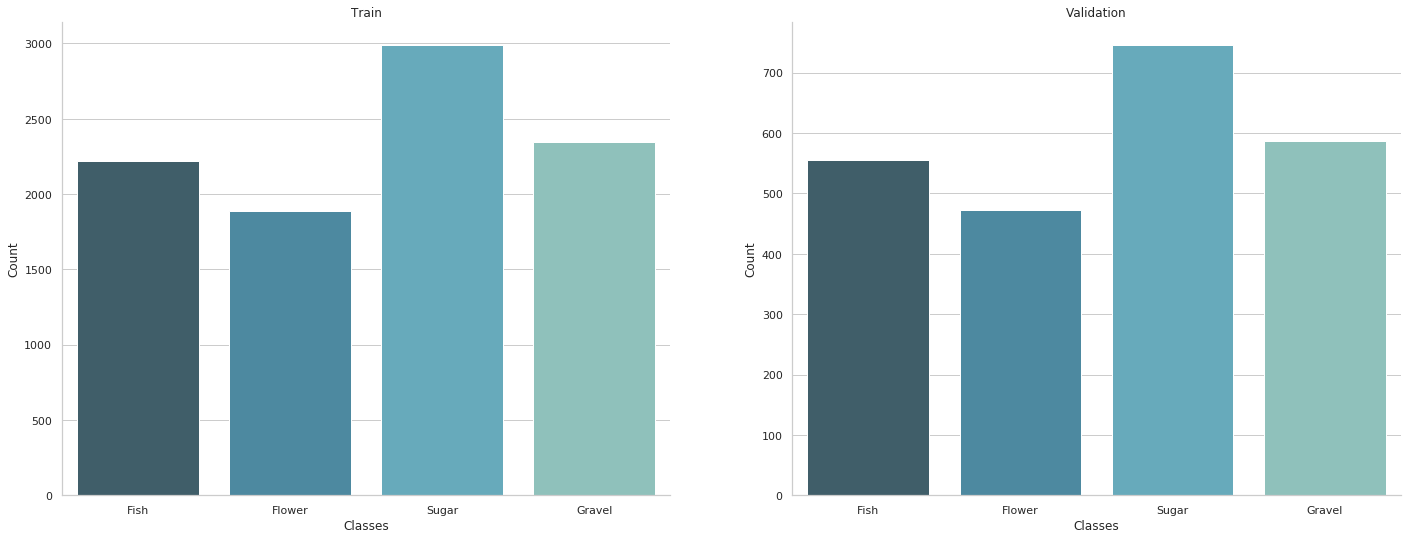

In [5]:
train_classes = train[['Fish', 'Flower', 'Sugar', 'Gravel']].agg(np.sum).reset_index()
validation_classes = validation[['Fish', 'Flower', 'Sugar', 'Gravel']].agg(np.sum).reset_index()
train_classes.columns = ['Classes', 'Count']
validation_classes.columns = ['Classes', 'Count']

fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 8.7))
sns.barplot(x="Classes", y="Count", data=train_classes, palette="GnBu_d", ax=ax1).set_title('Train')
sns.barplot(x="Classes", y="Count", data=validation_classes, palette="GnBu_d", ax=ax2).set_title('Validation')
sns.despine()
plt.show()

### Mask count distribution

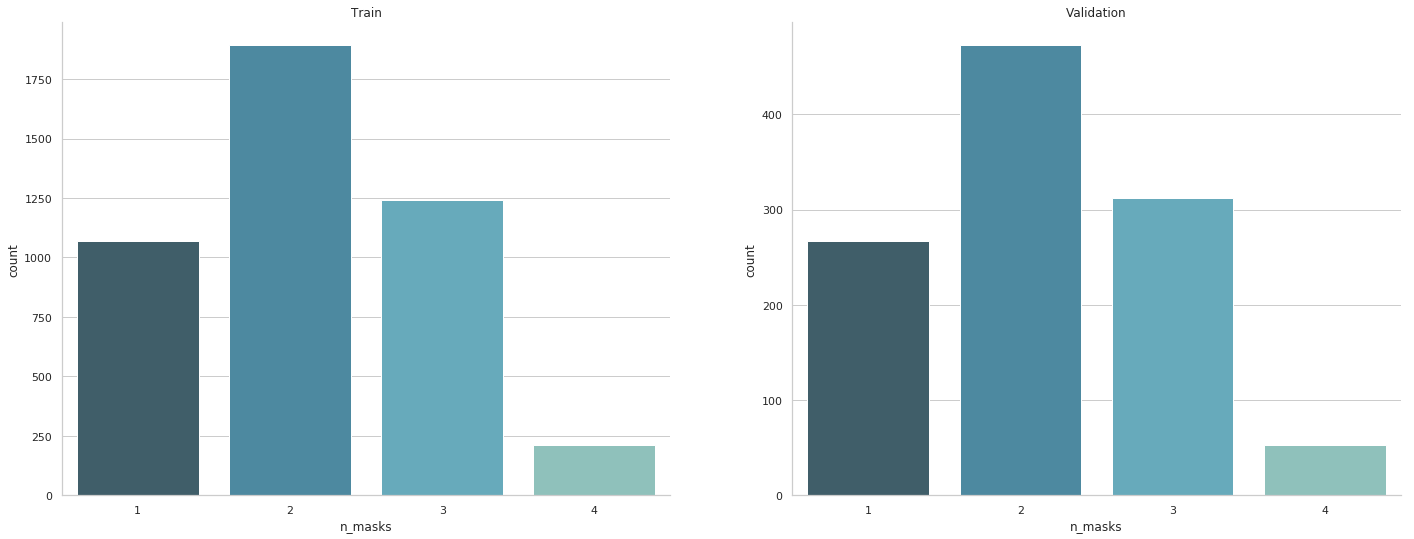

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 8.7))
sns.countplot(x="n_masks", data=train, palette="GnBu_d", ax=ax1).set_title('Train')
sns.countplot(x="n_masks", data=validation, palette="GnBu_d", ax=ax2).set_title('Validation')
sns.despine()
plt.show()

### Mask area distribution

In [7]:
display(train[['Fish_area', 'Flower_area', 'Gravel_area', 'Sugar_area']].describe().T)
display(validation[['Fish_area', 'Flower_area', 'Gravel_area', 'Sugar_area']].describe().T)

,count,mean,std,min,25%,50%,75%,max
Fish_area,4420.0,437382.476244,571219.269766,0.0,0.0,98612.5,768518.50,2852894.0
Flower_area,4420.0,406441.130995,604887.396919,0.0,0.0,0.0,714461.50,2884611.0
Gravel_area,4420.0,446018.994118,586581.925369,0.0,0.0,203460.5,740964.50,2838676.0
Sugar_area,4420.0,487673.990498,505725.759337,0.0,0.0,376552.0,790135.25,2662684.0


,count,mean,std,min,25%,50%,75%,max
Fish_area,1105.0,425882.141176,564855.225145,0.0,0.0,66800.0,753337.0,2744133.0
Flower_area,1105.0,412720.475113,600620.823298,0.0,0.0,0.0,723675.0,2699116.0
Gravel_area,1105.0,441122.905882,575987.374841,0.0,0.0,204721.0,726959.0,2850605.0
Sugar_area,1105.0,469013.329412,501142.862066,0.0,0.0,339923.0,751725.0,2714106.0


# Output hold-out set

In [8]:
train['set'] = 'train'
validation['set'] = 'validation'
train_complete = train.append(validation)[['image', 'Fish_mask', 'Flower_mask', 'Gravel_mask', 'Sugar_mask', 'Fish', 'Flower', 'Gravel', 'Sugar', 'set']]
train_complete.to_csv('hold-out.csv', index=False)
display(train_complete.head())

,image,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,Fish,Flower,Gravel,Sugar,set
701,1f3d231.jpg,NaN,1625401 196 1625598 4 1625607 1 1625612 5 1625...,NaN,NaN,0,1,0,0,train
336,0fa3287.jpg,NaN,121884 511 123284 511 124684 511 126084 511 12...,NaN,32739 369 34139 369 35539 369 36939 369 38339 ...,0,1,0,1,train
1656,4d17338.jpg,64 1141 1464 1141 2864 1141 4264 1141 5664 114...,NaN,NaN,13141 707 14541 707 15941 707 17341 707 18741 ...,1,0,0,1,train
409,12e55a8.jpg,NaN,1187509 1060 1188909 1060 1190309 1060 1191709...,NaN,2808 614 4208 614 5608 614 7008 614 8408 614 9...,0,1,0,1,train
2308,697eb53.jpg,52180 1006 53580 1006 54980 1006 56380 1006 57...,NaN,NaN,NaN,1,0,0,0,train


# 3-Fold split

In [9]:
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

for fold_n, (train_idx, val_idx) in enumerate(folds.split(train_df, train_df['n_masks'])):
    print('Fold: %s, Train size: %s, Validation size %s' % (fold_n, len(train_idx), len(val_idx)))
    train_df[('fold_%s' % fold_n)] = 0
    train_df[('fold_%s' % fold_n)].loc[train_idx] = 'train'
    train_df[('fold_%s' % fold_n)].loc[val_idx] = 'validation'
    
display(train_df.head())

Fold: 0, Train size: 3682, Validation size 1843
Fold: 1, Train size: 3683, Validation size 1842
Fold: 2, Train size: 3685, Validation size 1840


,image,label,Fish,Flower,Sugar,Gravel,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,n_masks,Fish_area,Flower_area,Gravel_area,Sugar_area,fold_0,fold_1,fold_2
0,0011165.jpg,"{Fish, Flower}",1,1,0,0,264918 937 266318 937 267718 937 269118 937 27...,1355565 1002 1356965 1002 1358365 1002 1359765...,NaN,NaN,2,932312,1156107,0,0,train,validation,train
1,002be4f.jpg,"{Fish, Flower, Sugar}",1,1,1,0,233813 878 235213 878 236613 878 238010 881 23...,1339279 519 1340679 519 1342079 519 1343479 51...,NaN,67495 350 68895 350 70295 350 71695 350 73095 ...,3,1684325,592697,0,313950,train,validation,train
2,0031ae9.jpg,"{Fish, Flower, Sugar}",1,1,1,0,3510 690 4910 690 6310 690 7710 690 9110 690 1...,2047 703 3447 703 4847 703 6247 703 7647 703 9...,NaN,658170 388 659570 388 660970 388 662370 388 66...,3,1240822,1178858,0,306908,train,train,validation
3,0035239.jpg,"{Gravel, Flower}",0,1,0,1,NaN,100812 462 102212 462 103612 462 105012 462 10...,65400 380 66800 380 68200 380 69600 380 71000 ...,NaN,2,0,655989,289939,0,validation,train,train
4,003994e.jpg,"{Gravel, Fish, Sugar}",1,0,1,1,2367966 18 2367985 2 2367993 8 2368002 62 2369...,NaN,353317 416 354717 416 356117 416 357517 416 35...,28011 489 29411 489 30811 489 32211 489 33611 ...,3,183231,0,410592,216627,train,validation,train


### Class distribution

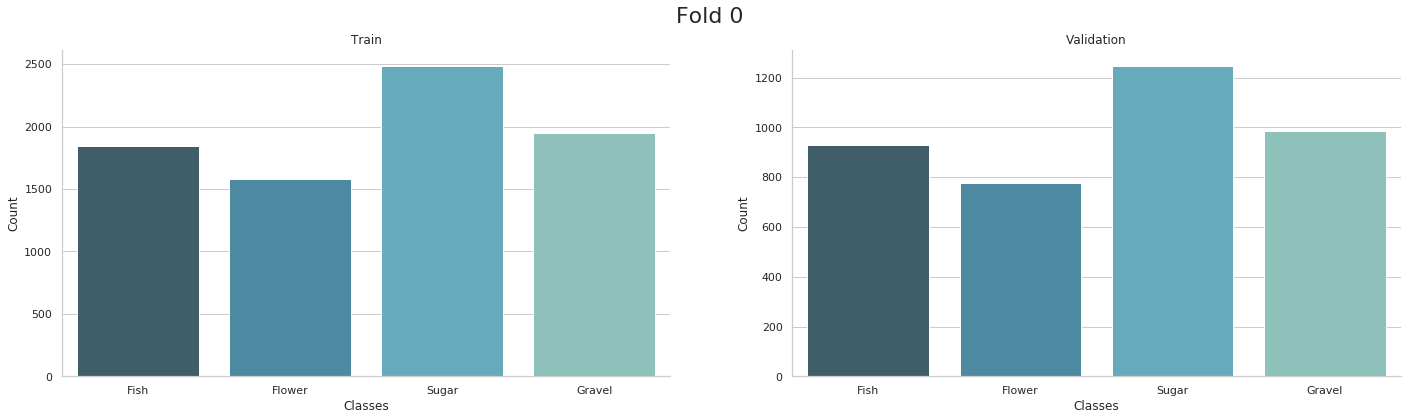

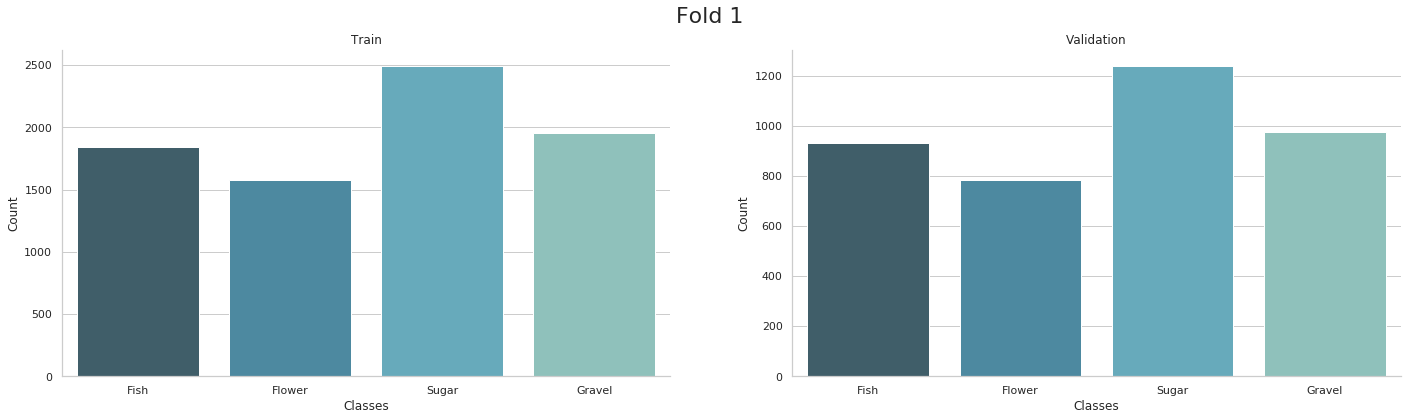

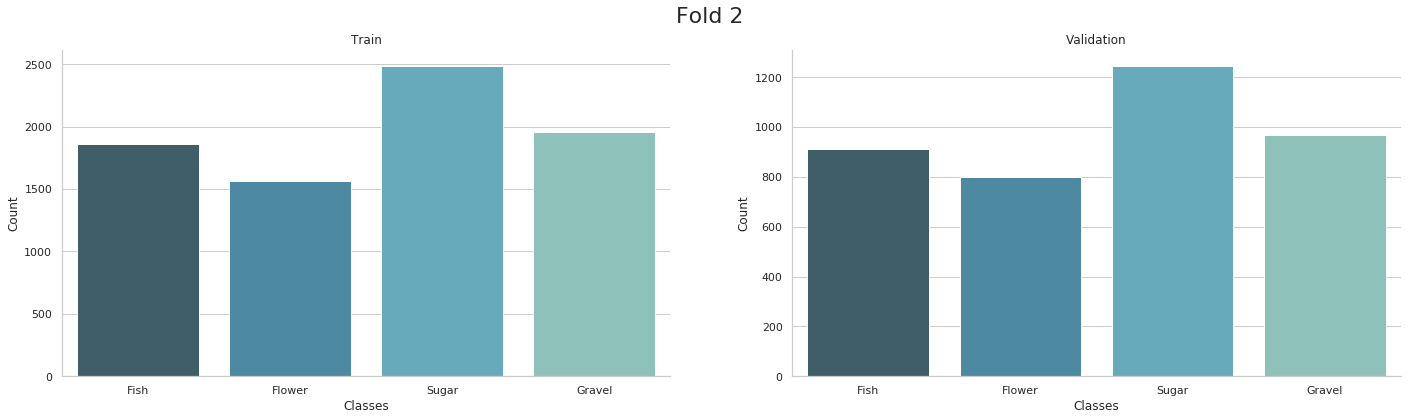

In [10]:
for fold_n in range(folds.n_splits):
    train_classes = train_df[train_df[('fold_%s' % fold_n)] == 'train'][['Fish', 'Flower', 'Sugar', 'Gravel']].agg(np.sum).reset_index()
    validation_classes = train_df[train_df[('fold_%s' % fold_n)] == 'validation'][['Fish', 'Flower', 'Sugar', 'Gravel']].agg(np.sum).reset_index()
    train_classes.columns = ['Classes', 'Count']
    validation_classes.columns = ['Classes', 'Count']

    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 6))
    fig.suptitle('Fold %s' % fold_n, fontsize=22)
    sns.barplot(x="Classes", y="Count", data=train_classes, palette="GnBu_d", ax=ax1).set_title('Train')
    sns.barplot(x="Classes", y="Count", data=validation_classes, palette="GnBu_d", ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

### Mask count distribution

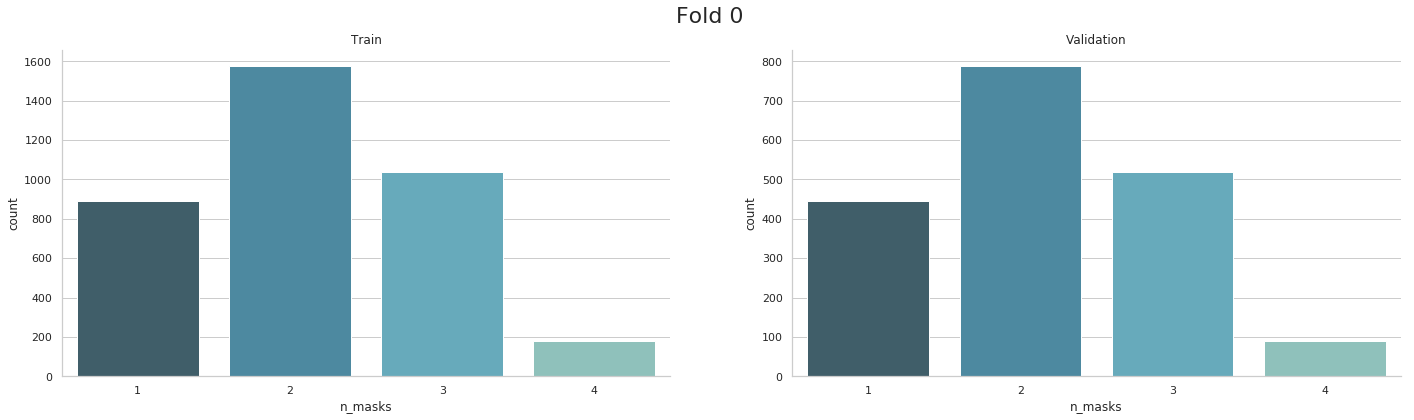

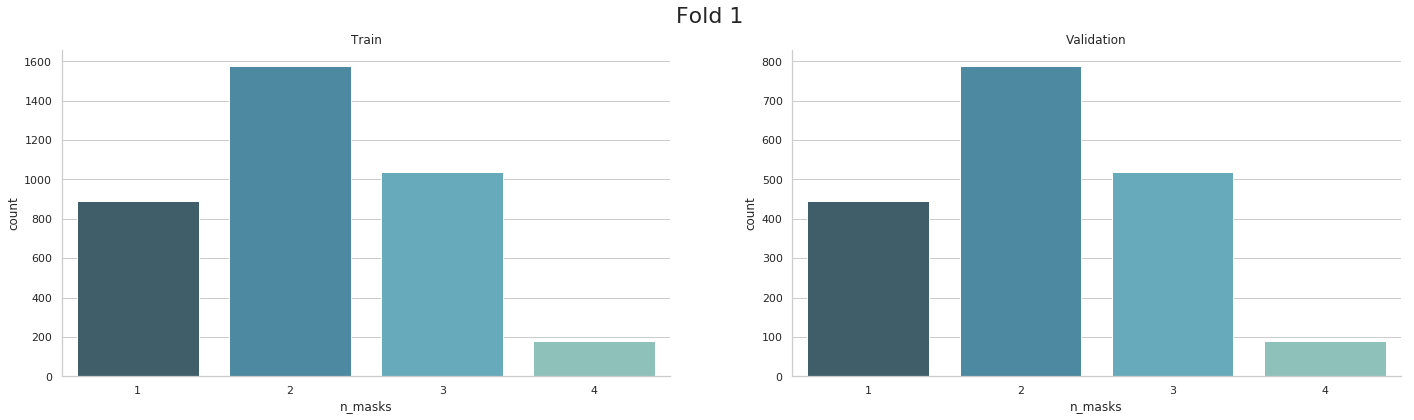

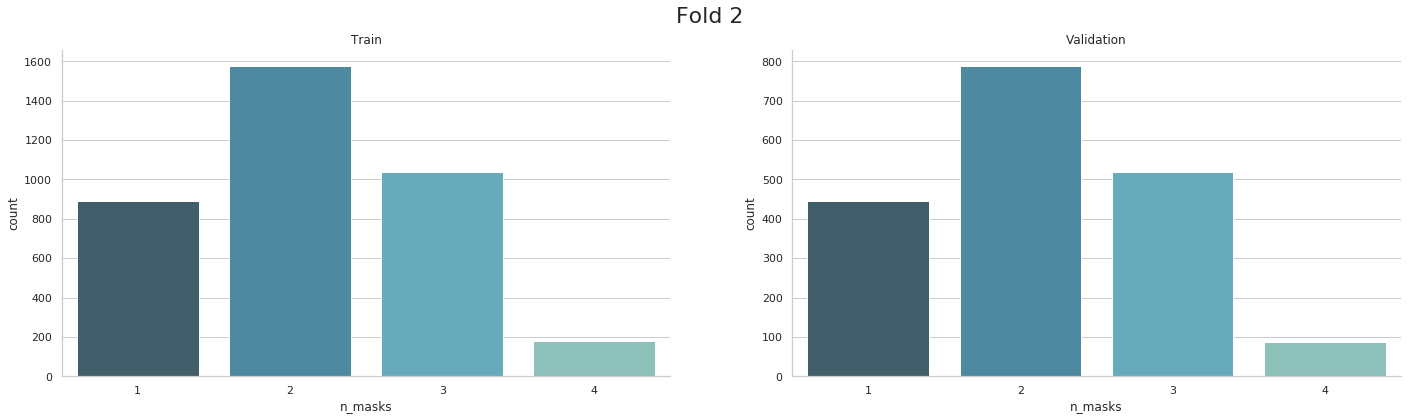

In [11]:
for fold_n in range(folds.n_splits):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 6))
    fig.suptitle('Fold %s' % fold_n, fontsize=22)    
    sns.countplot(x="n_masks", data=train_df[train_df[('fold_%s' % fold_n)] == 'train'], palette="GnBu_d", ax=ax1).set_title('Train')
    sns.countplot(x="n_masks", data=train_df[train_df[('fold_%s' % fold_n)] == 'validation'], palette="GnBu_d", ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

### Mask area distribution

In [12]:
for fold_n in range(folds.n_splits):
    print('Fold %s' % fold_n)    
    display(train_df[train_df[('fold_%s' % fold_n)] == 'train'][['Fish_area', 'Flower_area', 'Gravel_area', 'Sugar_area']].describe().T)
    display(train_df[train_df[('fold_%s' % fold_n)] == 'validation'][['Fish_area', 'Flower_area', 'Gravel_area', 'Sugar_area']].describe().T)

Fold 0


,count,mean,std,min,25%,50%,75%,max
Fish_area,3682.0,431831.172189,568193.083297,0.0,0.0,64751.0,759032.00,2824276.0
Flower_area,3682.0,411499.539924,605104.629383,0.0,0.0,0.0,730186.25,2884611.0
Gravel_area,3682.0,441116.276752,586661.029219,0.0,0.0,196717.0,722768.50,2850605.0
Sugar_area,3682.0,484774.713471,505925.006699,0.0,0.0,370888.0,784813.50,2714106.0


,count,mean,std,min,25%,50%,75%,max
Fish_area,1843.0,441577.826913,573453.406114,0.0,0.0,116935.0,789287.5,2852894.0
Flower_area,1843.0,400100.172545,601841.412633,0.0,0.0,0.0,705288.0,2804128.0
Gravel_area,1843.0,452878.260445,580025.889877,0.0,0.0,216825.0,760752.5,2791893.0
Sugar_area,1843.0,482277.955507,502745.536181,0.0,0.0,366618.0,780446.5,2553460.0


Fold 1


,count,mean,std,min,25%,50%,75%,max
Fish_area,3683.0,434863.715178,570865.982802,0.0,0.0,0.0,781613.0,2852894.0
Flower_area,3683.0,402506.072224,597867.566602,0.0,0.0,0.0,705288.0,2884611.0
Gravel_area,3683.0,448230.135759,582073.833420,0.0,0.0,212695.0,749636.0,2838676.0
Sugar_area,3683.0,486195.956286,502083.354540,0.0,0.0,372525.0,789702.0,2553460.0


,count,mean,std,min,25%,50%,75%,max
Fish_area,1842.0,435519.678610,568177.771990,0.0,0.0,138414.0,744492.00,2824276.0
Flower_area,1842.0,418076.036916,616074.606939,0.0,0.0,0.0,743303.75,2739192.0
Gravel_area,1842.0,438660.789902,589219.381702,0.0,0.0,184940.0,711264.25,2850605.0
Sugar_area,1842.0,479434.885993,510362.456989,0.0,0.0,362248.5,764308.00,2714106.0


Fold 2


,count,mean,std,min,25%,50%,75%,max
Fish_area,3685.0,438549.574763,570752.961763,0.0,0.0,119034.0,767095.0,2852894.0
Flower_area,3685.0,409085.665672,608981.348193,0.0,0.0,0.0,721055.0,2804128.0
Gravel_area,3685.0,445771.454274,584603.339338,0.0,0.0,202917.0,738528.0,2850605.0
Sugar_area,3685.0,480856.806513,506500.517414,0.0,0.0,365716.0,775361.0,2714106.0


,count,mean,std,min,25%,50%,75%,max
Fish_area,1840.0,428138.656522,568338.880036,0.0,0.0,0.0,765595.75,2744133.0
Flower_area,1840.0,404915.894565,594014.435338,0.0,0.0,0.0,703472.50,2884611.0
Gravel_area,1840.0,443574.432609,584238.513912,0.0,0.0,208542.5,733317.50,2838676.0
Sugar_area,1840.0,490120.345109,501525.189372,0.0,0.0,379042.0,799171.75,2491552.0


# Output 3-fold set

In [13]:
train_complete = train_df.drop(['label', 'Fish_area', 'Flower_area', 'Gravel_area', 'Sugar_area', 'n_masks'], axis=1)
train_complete.to_csv('3-fold.csv', index=False)
display(train_complete.head())

,image,Fish,Flower,Sugar,Gravel,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,fold_0,fold_1,fold_2
0,0011165.jpg,1,1,0,0,264918 937 266318 937 267718 937 269118 937 27...,1355565 1002 1356965 1002 1358365 1002 1359765...,NaN,NaN,train,validation,train
1,002be4f.jpg,1,1,1,0,233813 878 235213 878 236613 878 238010 881 23...,1339279 519 1340679 519 1342079 519 1343479 51...,NaN,67495 350 68895 350 70295 350 71695 350 73095 ...,train,validation,train
2,0031ae9.jpg,1,1,1,0,3510 690 4910 690 6310 690 7710 690 9110 690 1...,2047 703 3447 703 4847 703 6247 703 7647 703 9...,NaN,658170 388 659570 388 660970 388 662370 388 66...,train,train,validation
3,0035239.jpg,0,1,0,1,NaN,100812 462 102212 462 103612 462 105012 462 10...,65400 380 66800 380 68200 380 69600 380 71000 ...,NaN,validation,train,train
4,003994e.jpg,1,0,1,1,2367966 18 2367985 2 2367993 8 2368002 62 2369...,NaN,353317 416 354717 416 356117 416 357517 416 35...,28011 489 29411 489 30811 489 32211 489 33611 ...,train,validation,train


# 5-Fold split

In [14]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

for fold_n, (train_idx, val_idx) in enumerate(folds.split(train_df, train_df['n_masks'])):
    print('Fold: %s, Train size: %s, Validation size %s' % (fold_n, len(train_idx), len(val_idx)))
    train_df[('fold_%s' % fold_n)] = 0
    train_df[('fold_%s' % fold_n)].loc[train_idx] = 'train'
    train_df[('fold_%s' % fold_n)].loc[val_idx] = 'validation'
    
display(train_df.head())

Fold: 0, Train size: 4418, Validation size 1107
Fold: 1, Train size: 4419, Validation size 1106
Fold: 2, Train size: 4421, Validation size 1104
Fold: 3, Train size: 4421, Validation size 1104
Fold: 4, Train size: 4421, Validation size 1104


,image,label,Fish,Flower,Sugar,Gravel,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,n_masks,Fish_area,Flower_area,Gravel_area,Sugar_area,fold_0,fold_1,fold_2,fold_3,fold_4
0,0011165.jpg,"{Fish, Flower}",1,1,0,0,264918 937 266318 937 267718 937 269118 937 27...,1355565 1002 1356965 1002 1358365 1002 1359765...,NaN,NaN,2,932312,1156107,0,0,train,train,validation,train,train
1,002be4f.jpg,"{Fish, Flower, Sugar}",1,1,1,0,233813 878 235213 878 236613 878 238010 881 23...,1339279 519 1340679 519 1342079 519 1343479 51...,NaN,67495 350 68895 350 70295 350 71695 350 73095 ...,3,1684325,592697,0,313950,train,train,validation,train,train
2,0031ae9.jpg,"{Fish, Flower, Sugar}",1,1,1,0,3510 690 4910 690 6310 690 7710 690 9110 690 1...,2047 703 3447 703 4847 703 6247 703 7647 703 9...,NaN,658170 388 659570 388 660970 388 662370 388 66...,3,1240822,1178858,0,306908,train,train,train,train,validation
3,0035239.jpg,"{Gravel, Flower}",0,1,0,1,NaN,100812 462 102212 462 103612 462 105012 462 10...,65400 380 66800 380 68200 380 69600 380 71000 ...,NaN,2,0,655989,289939,0,validation,train,train,train,train
4,003994e.jpg,"{Gravel, Fish, Sugar}",1,0,1,1,2367966 18 2367985 2 2367993 8 2368002 62 2369...,NaN,353317 416 354717 416 356117 416 357517 416 35...,28011 489 29411 489 30811 489 32211 489 33611 ...,3,183231,0,410592,216627,train,train,validation,train,train


### Class distribution

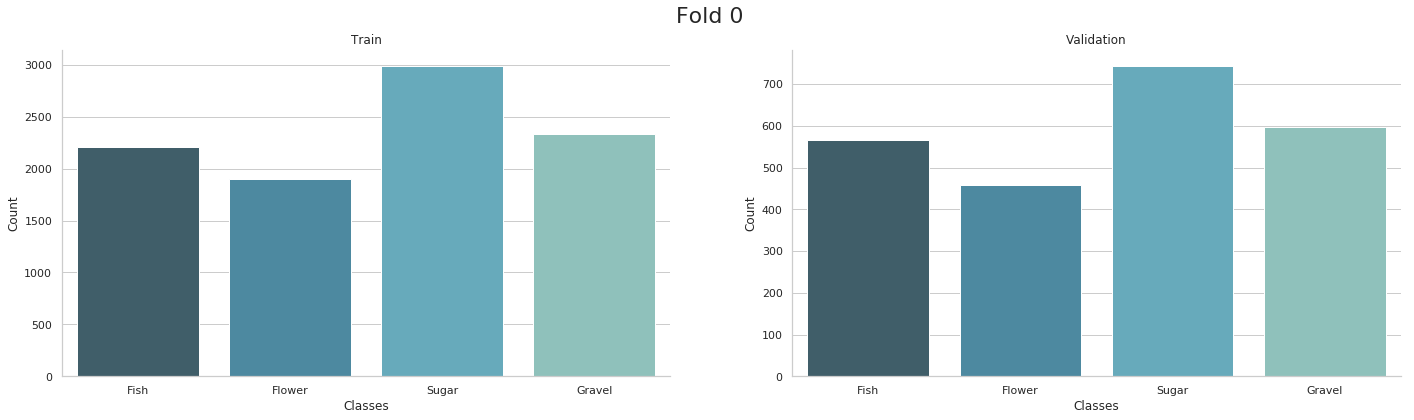

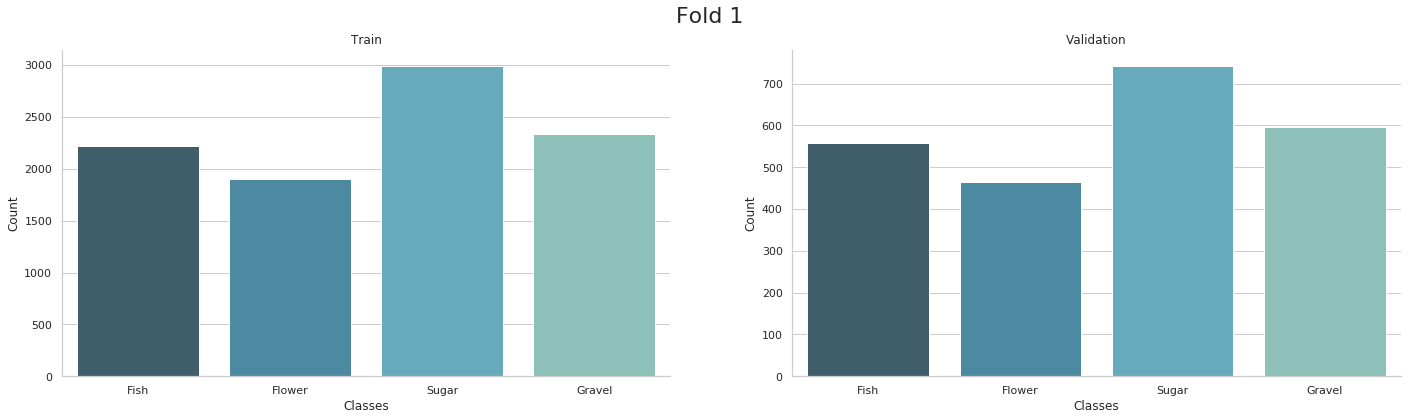

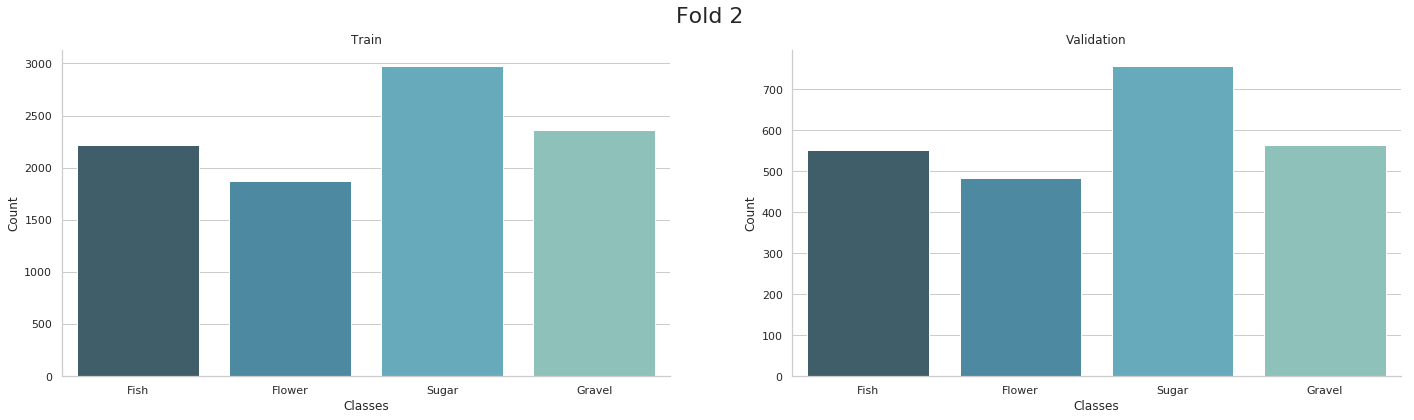

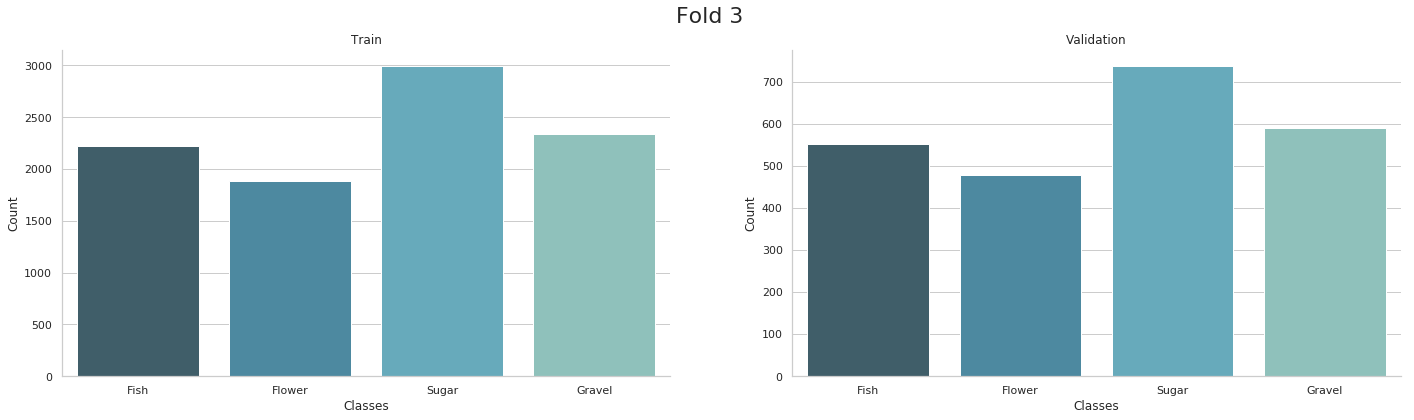

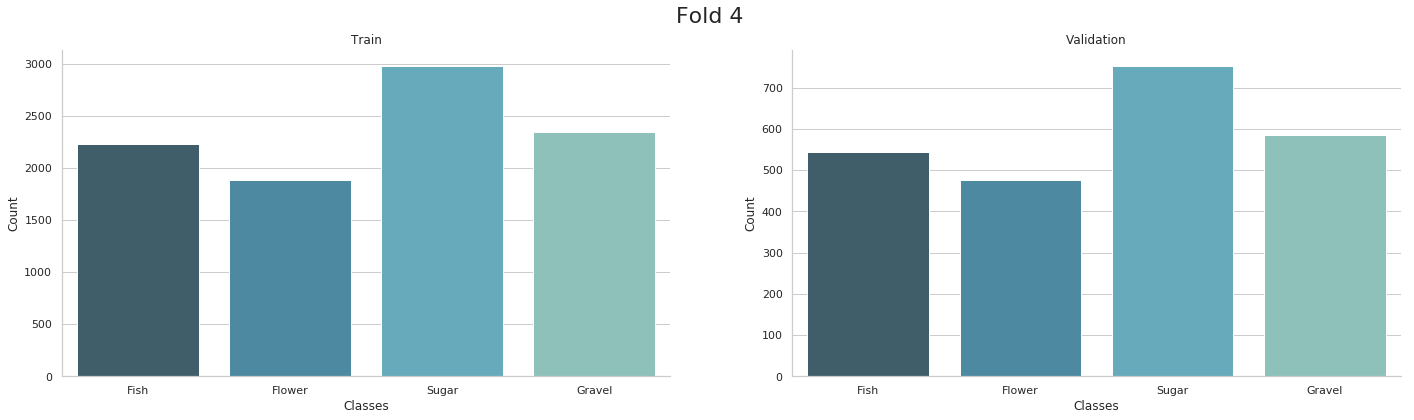

In [15]:
for fold_n in range(folds.n_splits):
    train_classes = train_df[train_df[('fold_%s' % fold_n)] == 'train'][['Fish', 'Flower', 'Sugar', 'Gravel']].agg(np.sum).reset_index()
    validation_classes = train_df[train_df[('fold_%s' % fold_n)] == 'validation'][['Fish', 'Flower', 'Sugar', 'Gravel']].agg(np.sum).reset_index()
    train_classes.columns = ['Classes', 'Count']
    validation_classes.columns = ['Classes', 'Count']

    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 6))
    fig.suptitle('Fold %s' % fold_n, fontsize=22)
    sns.barplot(x="Classes", y="Count", data=train_classes, palette="GnBu_d", ax=ax1).set_title('Train')
    sns.barplot(x="Classes", y="Count", data=validation_classes, palette="GnBu_d", ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

### Mask count distribution

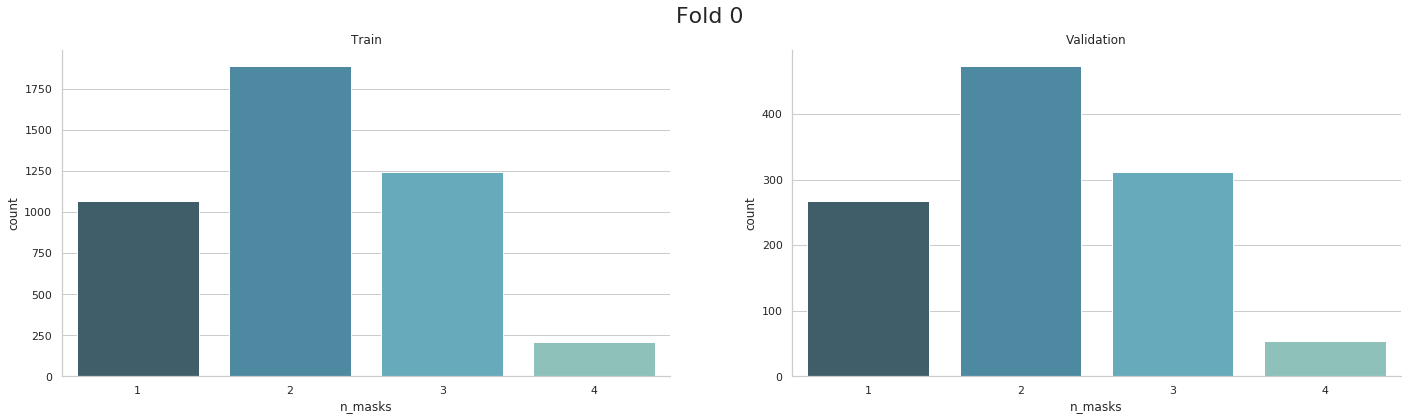

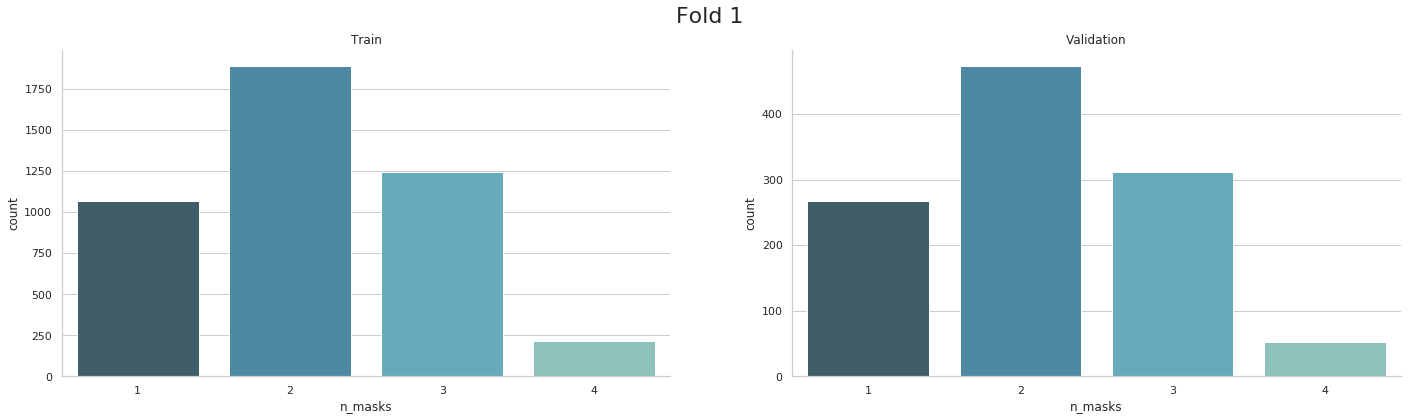

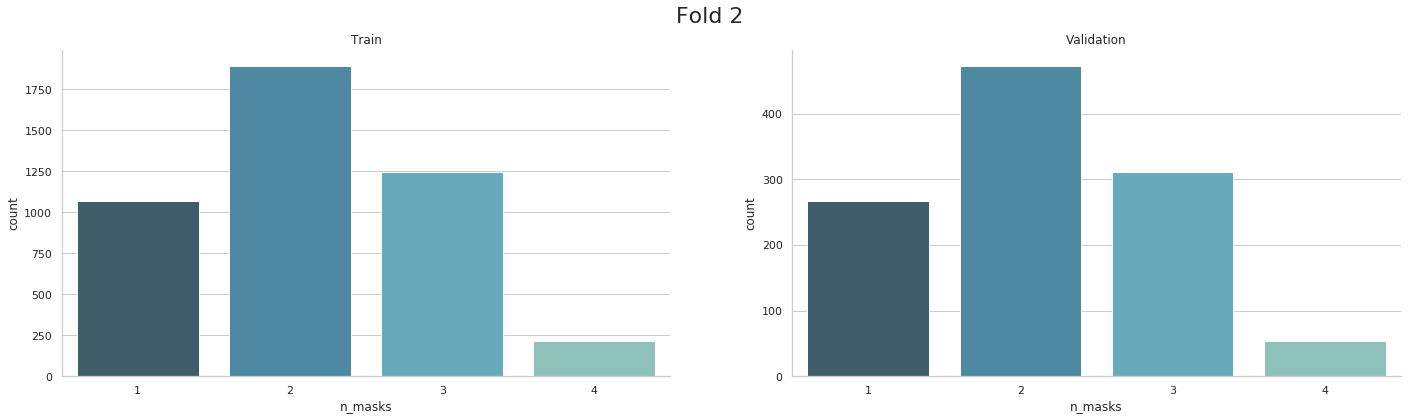

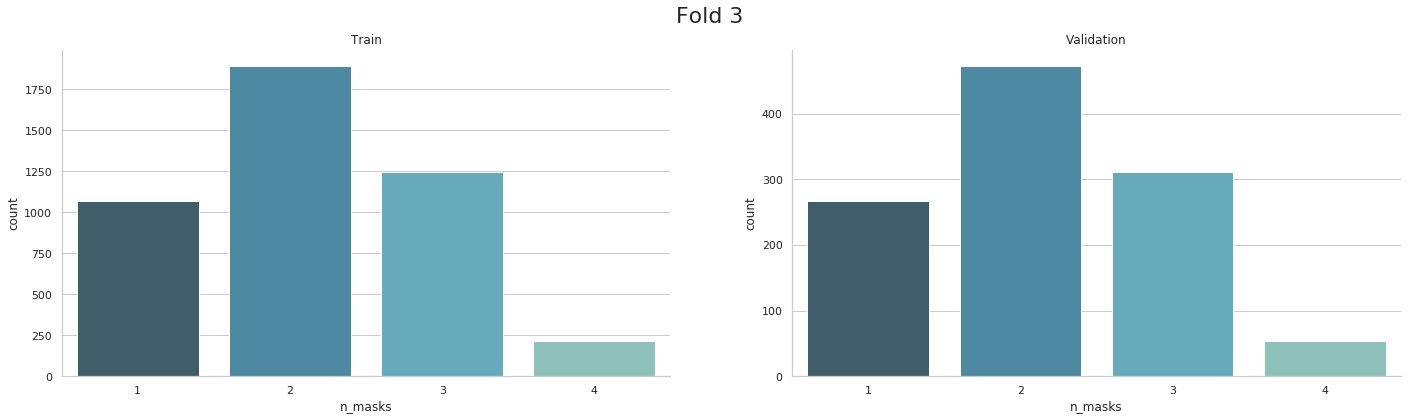

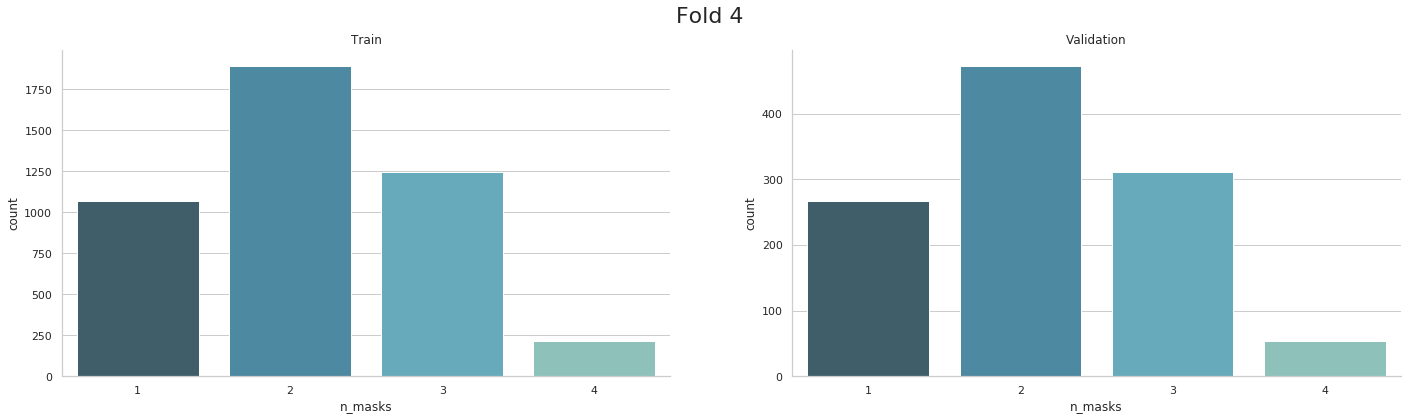

In [16]:
for fold_n in range(folds.n_splits):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 6))
    fig.suptitle('Fold %s' % fold_n, fontsize=22)    
    sns.countplot(x="n_masks", data=train_df[train_df[('fold_%s' % fold_n)] == 'train'], palette="GnBu_d", ax=ax1).set_title('Train')
    sns.countplot(x="n_masks", data=train_df[train_df[('fold_%s' % fold_n)] == 'validation'], palette="GnBu_d", ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

### Mask area distribution

In [17]:
for fold_n in range(folds.n_splits):
    print('Fold %s' % fold_n)    
    display(train_df[train_df[('fold_%s' % fold_n)] == 'train'][['Fish_area', 'Flower_area', 'Gravel_area', 'Sugar_area']].describe().T)
    display(train_df[train_df[('fold_%s' % fold_n)] == 'validation'][['Fish_area', 'Flower_area', 'Gravel_area', 'Sugar_area']].describe().T)

Fold 0


,count,mean,std,min,25%,50%,75%,max
Fish_area,4418.0,429327.877773,564865.747108,0.0,0.0,0.0,753285.75,2852894.0
Flower_area,4418.0,410592.815980,604977.133454,0.0,0.0,0.0,721977.25,2884611.0
Gravel_area,4418.0,439986.215935,581871.185696,0.0,0.0,197180.0,721852.50,2850605.0
Sugar_area,4418.0,486923.606609,508547.078388,0.0,0.0,370888.0,786671.25,2714106.0


,count,mean,std,min,25%,50%,75%,max
Fish_area,1107.0,458048.551942,589361.428769,0.0,0.0,165600.0,834850.0,2721345.0
Flower_area,1107.0,396139.894309,600154.493319,0.0,0.0,0.0,699036.5,2804128.0
Gravel_area,1107.0,465208.367660,594370.263513,0.0,0.0,230912.0,791876.0,2780960.0
Sugar_area,1107.0,472041.800361,489719.659106,0.0,0.0,365716.0,768599.0,2437213.0


Fold 1


,count,mean,std,min,25%,50%,75%,max
Fish_area,4419.0,436919.532473,574186.693478,0.0,0.0,74240.0,775795.5,2767797.0
Flower_area,4419.0,410399.992532,605877.582105,0.0,0.0,0.0,724098.5,2884611.0
Gravel_area,4419.0,445001.140982,589016.952388,0.0,0.0,198112.0,737136.0,2850605.0
Sugar_area,4419.0,481135.736366,499967.160223,0.0,0.0,367548.0,776542.0,2709609.0


,count,mean,std,min,25%,50%,75%,max
Fish_area,1106.0,427742.221519,552735.816647,0.0,0.0,117150.0,748765.75,2852894.0
Flower_area,1106.0,396897.248644,596525.152574,0.0,0.0,0.0,706316.25,2736979.0
Gravel_area,1106.0,445194.143761,565991.582178,0.0,0.0,226476.5,734640.25,2791893.0
Sugar_area,1106.0,495153.660036,523855.570929,0.0,0.0,378586.5,803312.25,2714106.0


Fold 2


,count,mean,std,min,25%,50%,75%,max
Fish_area,4421.0,437564.448315,571110.529964,0.0,0.0,100969.0,781654.0,2852894.0
Flower_area,4421.0,402519.767021,599424.177069,0.0,0.0,0.0,709140.0,2884611.0
Gravel_area,4421.0,450197.772676,584335.342736,0.0,0.0,217867.0,747977.0,2838676.0
Sugar_area,4421.0,483314.623162,503000.323655,0.0,0.0,370468.0,786273.0,2714106.0


,count,mean,std,min,25%,50%,75%,max
Fish_area,1104.0,425143.011775,565274.325250,0.0,0.0,2607.0,728626.5,2767797.0
Flower_area,1104.0,428429.378623,621771.704476,0.0,0.0,0.0,778531.0,2739192.0
Gravel_area,1104.0,424384.431159,584617.108384,0.0,0.0,137072.0,697429.5,2850605.0
Sugar_area,1104.0,486453.639493,512277.255562,0.0,0.0,362248.5,764284.0,2662684.0


Fold 3


,count,mean,std,min,25%,50%,75%,max
Fish_area,4421.0,433076.377969,566759.277757,0.0,0.0,96256.0,765082.0,2852894.0
Flower_area,4421.0,404773.390862,601980.720558,0.0,0.0,0.0,711298.0,2804128.0
Gravel_area,4421.0,446255.578376,585365.622905,0.0,0.0,209248.0,740007.0,2850605.0
Sugar_area,4421.0,486844.841891,508457.135519,0.0,0.0,369846.0,784982.0,2714106.0


,count,mean,std,min,25%,50%,75%,max
Fish_area,1104.0,443115.619565,582596.309973,0.0,0.0,63830.5,782214.00,2546035.0
Flower_area,1104.0,419404.676630,612093.294534,0.0,0.0,0.0,730728.25,2884611.0
Gravel_area,1104.0,440171.062500,580906.154354,0.0,0.0,193379.5,721689.25,2742116.0
Sugar_area,1104.0,472316.776268,490050.478504,0.0,0.0,369102.0,778617.25,2709609.0


Fold 4


,count,mean,std,min,25%,50%,75%,max
Fish_area,4421.0,438520.735806,572633.645455,0.0,0.0,112336.0,767350.0,2852894.0
Flower_area,4421.0,410202.220538,607664.765819,0.0,0.0,0.0,719157.0,2884611.0
Gravel_area,4421.0,443754.727663,581548.107000,0.0,0.0,201408.0,736761.0,2850605.0
Sugar_area,4421.0,481491.237277,504113.042312,0.0,0.0,367548.0,779287.0,2714106.0


,count,mean,std,min,25%,50%,75%,max
Fish_area,1104.0,421313.530797,558963.902848,0.0,0.0,0.0,760794.25,2744133.0
Flower_area,1104.0,397664.770833,589195.361973,0.0,0.0,0.0,703472.50,2569530.0
Gravel_area,1104.0,450185.791667,596070.166267,0.0,0.0,227527.5,737434.75,2838676.0
Sugar_area,1104.0,493755.441123,507764.463226,0.0,0.0,374405.5,805407.50,2491552.0


# Output 5-fold set

In [18]:
train_complete = train_df.drop(['label', 'Fish_area', 'Flower_area', 'Gravel_area', 'Sugar_area', 'n_masks'], axis=1)
train_complete.to_csv('5-fold.csv', index=False)
display(train_complete.head())

,image,Fish,Flower,Sugar,Gravel,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,fold_0,fold_1,fold_2,fold_3,fold_4
0,0011165.jpg,1,1,0,0,264918 937 266318 937 267718 937 269118 937 27...,1355565 1002 1356965 1002 1358365 1002 1359765...,NaN,NaN,train,train,validation,train,train
1,002be4f.jpg,1,1,1,0,233813 878 235213 878 236613 878 238010 881 23...,1339279 519 1340679 519 1342079 519 1343479 51...,NaN,67495 350 68895 350 70295 350 71695 350 73095 ...,train,train,validation,train,train
2,0031ae9.jpg,1,1,1,0,3510 690 4910 690 6310 690 7710 690 9110 690 1...,2047 703 3447 703 4847 703 6247 703 7647 703 9...,NaN,658170 388 659570 388 660970 388 662370 388 66...,train,train,train,train,validation
3,0035239.jpg,0,1,0,1,NaN,100812 462 102212 462 103612 462 105012 462 10...,65400 380 66800 380 68200 380 69600 380 71000 ...,NaN,validation,train,train,train,train
4,003994e.jpg,1,0,1,1,2367966 18 2367985 2 2367993 8 2368002 62 2369...,NaN,353317 416 354717 416 356117 416 357517 416 35...,28011 489 29411 489 30811 489 32211 489 33611 ...,train,train,validation,train,train
